# Effective Area Plotting Example
Author: Michael Larson
Last Update: 24 April 2023

This repository is intended to serve as an example for anyone who needs to build an effective area 
curve. This script is a minimal working example used to extract information from i3 files generated 
by neutrino-generator or GENIE.


In [6]:
import os, sys, glob
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

# Wrap the plotting for effective area
There's some specific factors that need to be included when plotting an effective area. Wrap it all in a function for clarity.

In [7]:
def make_aeff(ax, x, 
              ebins = np.logspace(0, 5, 101), 
              dec_min = -np.pi/2.,
              dec_max = np.pi/2.,
              **kwargs):

    # Mask the events to the correct range of declinations and
    # histogram the 'oneweight' values. This will give us a histogram
    # in the same units as 'ow', which means we'll have `GeV cm2 sr`
    # after this step.
    mask = (dec_min <= x['trueDec']) & (x['trueDec'] <= dec_max)
    h, b = np.histogram(x['trueE'][mask],
                        weights = x['ow'][mask],
                        bins=ebins)

    # Now account for the phase space, which will reduce us from
    # `GeV cm2 sr` to `cm2`
    h /= np.diff(b)
    h /= 2*np.pi
    h /= (np.sin(x['trueDec'].max()) - np.sin(x['trueDec'].min()))
    
    # And now we're finally at an effective area curve!
    # It's currently in cm^2. Convert it to m^2
    h /= 1e4 

    # Now plot it onto the axis and return.
    _ = ax.hist(b[:-1],
                bins = b,
                weights = h,
                **kwargs)
    return


## Load our input files. 
Here I'm assuming that we have a numpy structured array. This acts like a dictionary or a pandas dataframe
with fields ['trueDec', 'ow', 'trueE']

In [8]:
oscnext = np.load("./oscnext_140000.npy")
greco = np.load("/data/ana/analyses/greco_online/version-002-p11/IC86_2012.numu_merged.npy")

## Make a plot with effective area averaged over the full sky

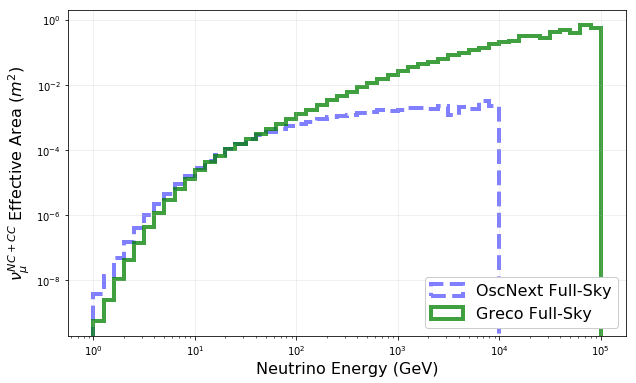

In [13]:
# And now in declination bins...
ebins = np.logspace(0, 5, 51)
dec_bins = np.radians([-90, 90])

fig, ax = plt.subplots(figsize=(10,6))
make_aeff(ax, oscnext, ebins,
          dec_min = -np.pi/2,
          dec_max = np.pi/2,
          histtype='step',
          linewidth=4,
          linestyle = 'dashed',
          color='b',
          alpha=0.5,
          label='OscNext Full-Sky')
    
make_aeff(ax, greco, ebins, 
          dec_min = -np.pi/2,
          dec_max = np.pi/2,
          histtype='step',
          linewidth=4,
          linestyle='solid',
          color='g',
          alpha=0.75,
          label='Greco Full-Sky')

ax.grid(alpha=0.25)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='lower right', fontsize=16, framealpha = 1,)
ax.set_xlabel("Neutrino Energy (GeV)", fontsize=16)
ax.set_ylabel(r"$\nu_\mu^{NC+CC}$ Effective Area ($m^2$)", fontsize=16)
fig.savefig("oscnext_greco_aeff.pdf")

## And one with effective areas broken out into several bins.

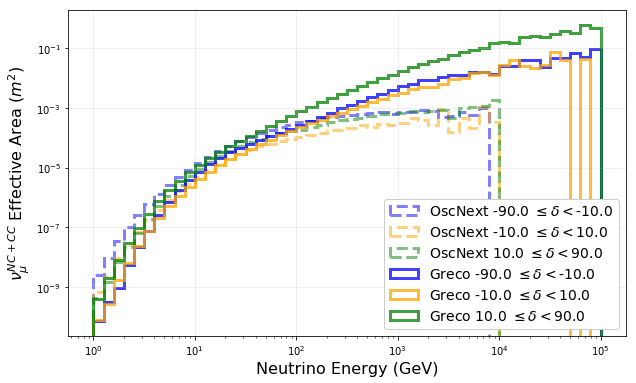

In [14]:
# And now in declination bins...
ebins = np.logspace(0, 5, 51)
dec_bins = np.radians([-90, -10, 10, 90])
colors = ['blue', 'orange', 'green']

fig, ax = plt.subplots(figsize=(10,6))

for c, (dmin, dmax) in zip(colors, zip(dec_bins[:-1], dec_bins[1:])):
    label = f"{np.degrees(dmin)} " + r"$\leq \delta <$" + f"{np.degrees(dmax)}"
    make_aeff(ax, oscnext, ebins, 
              dec_min = dmin,
              dec_max = dmax,
              histtype='step',
              linewidth=3,
              linestyle = 'dashed',
              color=c,
              alpha=0.5,
              label='OscNext ' + label)
    
    
for c, (dmin, dmax) in zip(colors, zip(dec_bins[:-1], dec_bins[1:])):
    label = f"{np.degrees(dmin)} " + r"$\leq \delta <$" + f"{np.degrees(dmax)}"
    make_aeff(ax, greco, ebins, 
              dec_min = dmin,
              dec_max = dmax,
              histtype='step',
              linewidth=3,
              linestyle='solid',
              color=c,
              alpha=0.75,
              label='Greco ' + label)

ax.grid(alpha=0.25)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='lower right', fontsize=14, framealpha = 1,)
ax.set_xlabel("Neutrino Energy (GeV)", fontsize=16)
ax.set_ylabel(r"$\nu_\mu^{NC+CC}$ Effective Area ($m^2$)", fontsize=16)
fig.savefig("oscnext_greco_aeff.pdf")